<a href="https://colab.research.google.com/github/IsidoraJevremovic/osnovi-astronomije/blob/main/proba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install cirq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.7/532.7 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━

Ensemble 1, Epoch [500/8000], Loss: 0.0207
Ensemble 1, Epoch [1000/8000], Loss: 0.0120
Ensemble 1, Epoch [1500/8000], Loss: 0.0089
Ensemble 1, Epoch [2000/8000], Loss: 0.0071
Ensemble 1, Epoch [2500/8000], Loss: 0.0052
Ensemble 1, Epoch [3000/8000], Loss: 0.0052
Ensemble 1, Epoch [3500/8000], Loss: 0.0043
Ensemble 1, Epoch [4000/8000], Loss: 0.0047
Ensemble 1, Epoch [4500/8000], Loss: 0.0039
Ensemble 1, Epoch [5000/8000], Loss: 0.0037
Ensemble 1, Epoch [5500/8000], Loss: 0.0034
Ensemble 1, Epoch [6000/8000], Loss: 0.0032
Ensemble 1, Epoch [6500/8000], Loss: 0.0030
Ensemble 1, Epoch [7000/8000], Loss: 0.0029
Ensemble 1, Epoch [7500/8000], Loss: 0.0027
Ensemble 1, Epoch [8000/8000], Loss: 0.0028
Mean Absolute Error (MAE): 0.0356


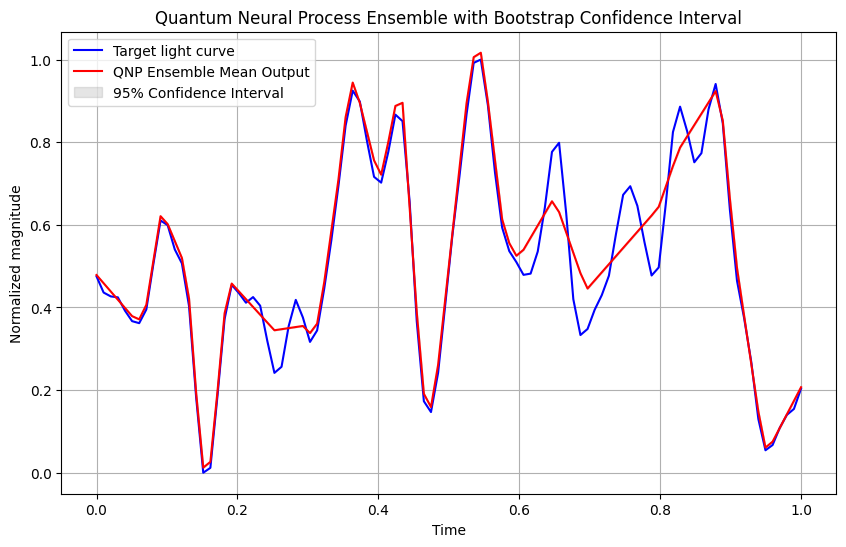

In [3]:
 import cirq
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

num_qubits = 4
depth = 4
qubits = cirq.LineQubit.range(num_qubits)

def create_circuit(params):
    circuit = cirq.Circuit()
    index = 0
    for layer in range(depth):
        for i in range(num_qubits):
            circuit.append(cirq.rx(params[index])(qubits[i]))
            index += 1
            circuit.append(cirq.ry(params[index])(qubits[i]))
            index += 1
            circuit.append(cirq.rz(params[index])(qubits[i]))
            index += 1
        if num_qubits > 1:
            for i in range(num_qubits - 1):
                circuit.append(cirq.CNOT(qubits[i], qubits[i + 1]))
    return circuit

def simulate_circuit(circuit):
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit)
    final_state = result.final_state_vector
    return np.real(final_state)

class QuantumEncoder(nn.Module):
    def __init__(self, num_qubits, depth, latent_dim):
        super(QuantumEncoder, self).__init__()
        self.num_qubits = num_qubits
        self.depth = depth
        self.latent_dim = latent_dim
        self.num_params = num_qubits * depth * 3
        self.params = nn.Parameter(torch.randn(self.num_params, dtype=torch.float32))

    def forward(self, x_context, y_context):
        params = self.params.detach().numpy()
        circuit = create_circuit(params)
        r = simulate_circuit(circuit)
        r = torch.tensor(r[:self.latent_dim], dtype=torch.float32)
        return r

class NeuralDecoder(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, hidden_dim=128):
        super(NeuralDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(input_dim + latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x_target, r_target):
        decoder_input = torch.cat([x_target, r_target], dim=-1)
        y_pred = self.decoder(decoder_input)
        return y_pred

class QuantumNeuralProcess(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, depth, num_qubits):
        super(QuantumNeuralProcess, self).__init__()
        self.encoder = QuantumEncoder(num_qubits, depth, latent_dim)
        self.decoder = NeuralDecoder(input_dim, latent_dim, output_dim)

    def forward(self, x_context, y_context, x_target):
        r = self.encoder(x_context, y_context)
        r_target = r.expand(x_target.size(0), -1)
        y_pred = self.decoder(x_target, r_target)
        return y_pred

# Load the data without headers
data = pd.read_csv("6(1).csv", header=None)

# Ensure the DataFrame has at least two columns
if data.shape[1] < 3:
    raise ValueError("The input CSV file does not have the required three columns.")

# Extract time_points and magnitude from the DataFrame
time_points = data.iloc[:, 0].values
magnitude = data.iloc[:, 1].values

# Normalize the time points and magnitude
time_points = (time_points - np.min(time_points)) / (np.max(time_points) - np.min(time_points))
magnitude = (magnitude - np.min(magnitude)) / (np.max(magnitude) - np.min(magnitude))

x_context = torch.tensor(time_points, dtype=torch.float32).unsqueeze(-1)
y_context = torch.tensor(magnitude, dtype=torch.float32).unsqueeze(-1)
x_target = torch.tensor(time_points, dtype=torch.float32).unsqueeze(-1)
y_target = torch.tensor(magnitude, dtype=torch.float32).unsqueeze(-1)

input_dim = 1
latent_dim = 4
output_dim = 1

n_ensembles = 1
n_bootstraps = 50
num_epochs = 8000
all_preds = np.zeros((n_ensembles * n_bootstraps, len(x_target)))

for i in range(n_ensembles):
    qnp_model = QuantumNeuralProcess(input_dim, latent_dim, output_dim, depth, num_qubits)
    optimizer = torch.optim.Adam(qnp_model.parameters(), lr=1e-2)

    # Implementing the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

    loss_fn = nn.MSELoss()

    for epoch in range(num_epochs):
        qnp_model.train()
        optimizer.zero_grad()
        y_pred = qnp_model(x_context, y_context, x_target)
        loss = loss_fn(y_pred, y_target)
        loss.backward()
        optimizer.step()

        # Step the learning rate scheduler
        scheduler.step()

        if (epoch + 1) % 500 == 0:
            print(f'Ensemble {i+1}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Bootstrap resampling and prediction
    for j in range(n_bootstraps):
        indices = np.random.choice(len(x_context), len(x_context), replace=True)
        x_context_bootstrap = x_context[indices]
        y_context_bootstrap = y_context[indices]

        qnp_model.eval()
        with torch.no_grad():
            y_pred_bootstrap = qnp_model(x_context_bootstrap, y_context_bootstrap, x_target).numpy().flatten()
            all_preds[i * n_bootstraps + j] = y_pred_bootstrap

# Calculate the mean prediction across the ensemble and bootstrap samples
y_pred_mean = np.mean(all_preds, axis=0)

# Calculate the confidence intervals as the 2.5th and 97.5th percentiles
lower_bound = np.percentile(all_preds, 2.5, axis=0)
upper_bound = np.percentile(all_preds, 97.5, axis=0)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_target.numpy(), y_pred_mean)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(time_points, magnitude, label='Target light curve', color='blue')
plt.plot(time_points, y_pred_mean, label='QNP Ensemble Mean Output', color='red')
plt.fill_between(time_points, lower_bound, upper_bound, color='gray', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized magnitude')
plt.title('Quantum Neural Process Ensemble with Bootstrap Confidence Interval')
plt.grid(True)
plt.show()